# Plotting for Experiment: Server Resource Allocation

Post process and plotting for experiment launched by scripts/run-sec5-resource-allocation-exp.sh

In [1]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from rmexp import schema

In [14]:
# exps = ['face3pool3pingpong3lego3',
#         'face4pool4pingpong4lego4', 
#         'face5pool4pingpong4lego5',
#         'face5pool5pingpong5lego5',
#         'face5pool6pingpong5lego6',
#         'face5pool6pingpong6lego7',
#         'face5pool7pingpong7lego7',
#         'face8pool8pingpong8lego8']
exps = ['sec5-face3pool3pingpong3lego3ikea3',
        'sec5-face4pool4pingpong4lego4ikea4', 
        'sec5-face5pool4pingpong4lego5ikea5',
        'sec5-face5pool5pingpong5lego5ikea5',
        'sec5-face5pool6pingpong5lego6ikea5',
        'sec5-face5pool6pingpong6lego7ikea6',
        'sec5-face5pool7pingpong7lego7ikea6',
        'sec5-face8pool8pingpong8lego8ikea8'
]

assert len(exps) == len(set(exps)), "redundant!"

# find the number of clients in the experiemnts
get_client_num = map(lambda exp: sum(map(int, re.findall('\d+', exp.split('-')[-1]))) , exps)
exps_clients = get_client_num
print(exps_clients)

schemes = ['baseline', 'cpushares']
# apps = ['face', 'lego', 'pingpong', 'pool']
apps = ['face', 'lego', 'pingpong', 'pool', 'ikea']
experiment_time = 90 # 90s

def pretty_app(app):
    dct = {
        'face': 'FACE',
        'lego': 'LEGO',
        'pingpong': 'PING PONG',
        'pool': 'POOL',
        'ikea': 'IKEA'
    }
    return dct[app]

def pretty_scheme(scheme):
    dct = {
        'baseline': 'Original Gabriel',
        'cpushares': 'Scalable Gabriel',
    }
    return dct[scheme]

def pretty_color(scheme):
    dct = {
        'baseline': 'orange',
        'cpushares': 'navy',
    }
    return dct[scheme]

pretty_fmt = {
    'baseline': 'x-',
    'cpushares': 'o-'
}

app_bounds = {
    'lego': (600, 2700),
    'pingpong': (150, 230),
    'pool': (95, 105),
    'face': (370, 1000),
    'ikea': (600, 2700)
}

[15, 20, 23, 25, 27, 30, 32, 40]


## Max-Sum Utility

In [12]:
# compare total utility of different methods
total_utils = pd.DataFrame()

for scheme in schemes:
    for exp in exps:
        df = pd.read_sql(
            "select sum(utility)/count(distinct name) as utility from ExpLatency where name like %(name)s",
            schema.engine,
            params={'name': exp+'-'+scheme+'%'}
        )
        total_utils = total_utils.append({
            'exp': exp,
            'scheme': scheme,
            'total_utility': df['utility'].iat[0]
        }, ignore_index=True)
        
print(total_utils)

                                   exp     scheme  total_utility
0   sec5-face3pool3pingpong3lego3ikea3   baseline   10036.206665
1   sec5-face4pool4pingpong4lego4ikea4   baseline    9848.742138
2   sec5-face5pool4pingpong4lego5ikea5   baseline    8729.248756
3   sec5-face5pool5pingpong5lego5ikea5   baseline    8605.468775
4   sec5-face5pool6pingpong5lego6ikea5   baseline    7696.172770
5   sec5-face5pool6pingpong6lego7ikea6   baseline    6615.481000
6   sec5-face5pool7pingpong7lego7ikea6   baseline    6104.655706
7   sec5-face8pool8pingpong8lego8ikea8   baseline    5046.176070
8   sec5-face3pool3pingpong3lego3ikea3  cpushares    8626.979619
9   sec5-face4pool4pingpong4lego4ikea4  cpushares    9026.240736
10  sec5-face5pool4pingpong4lego5ikea5  cpushares   11549.027323
11  sec5-face5pool5pingpong5lego5ikea5  cpushares   11695.675976
12  sec5-face5pool6pingpong5lego6ikea5  cpushares   11561.987471
13  sec5-face5pool6pingpong6lego7ikea6  cpushares   10891.804472
14  sec5-face5pool7pingpo

<IPython.core.display.Javascript object>


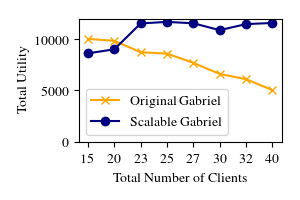

In [18]:
%matplotlib notebook

plt.figure(figsize=(3,2))
for idx, scheme in enumerate(schemes):
    plt.plot('exp', 'total_utility', 
             pretty_fmt[scheme], data=total_utils[total_utils['scheme'] == scheme], 
             label=pretty_scheme(scheme),
             color=pretty_color(scheme),
            )
plt.ylim([0, None])
plt.xticks(exps, exps_clients)
plt.xlabel('Total Number of Clients')
plt.ylabel('Total Utility')
plt.legend()
plt.tight_layout()
plt.savefig('figs/fig-alloc-max-util.pdf')

### Utility for Each Application

<IPython.core.display.Javascript object>


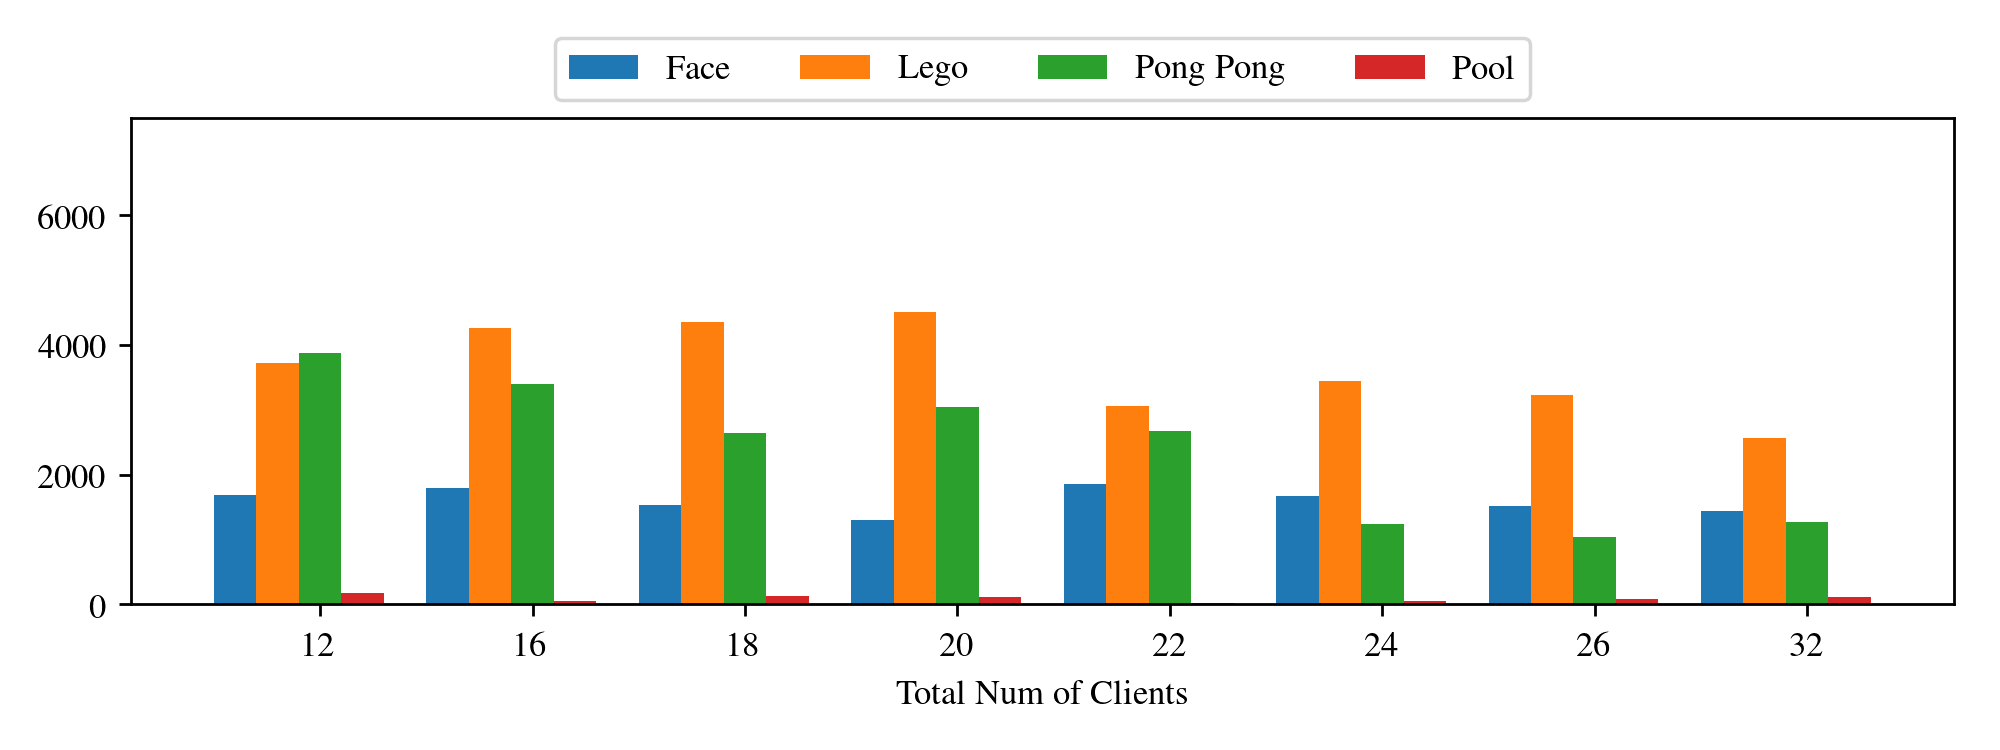

<IPython.core.display.Javascript object>


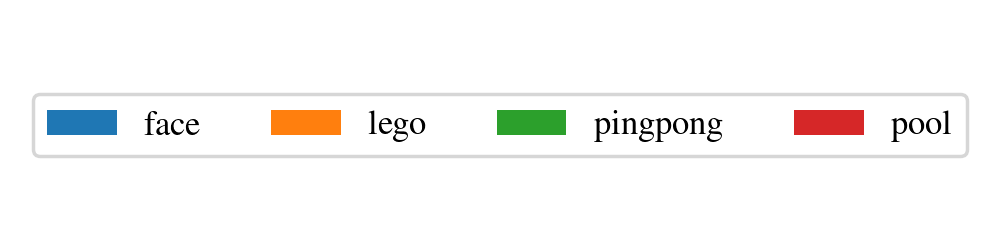

<IPython.core.display.Javascript object>


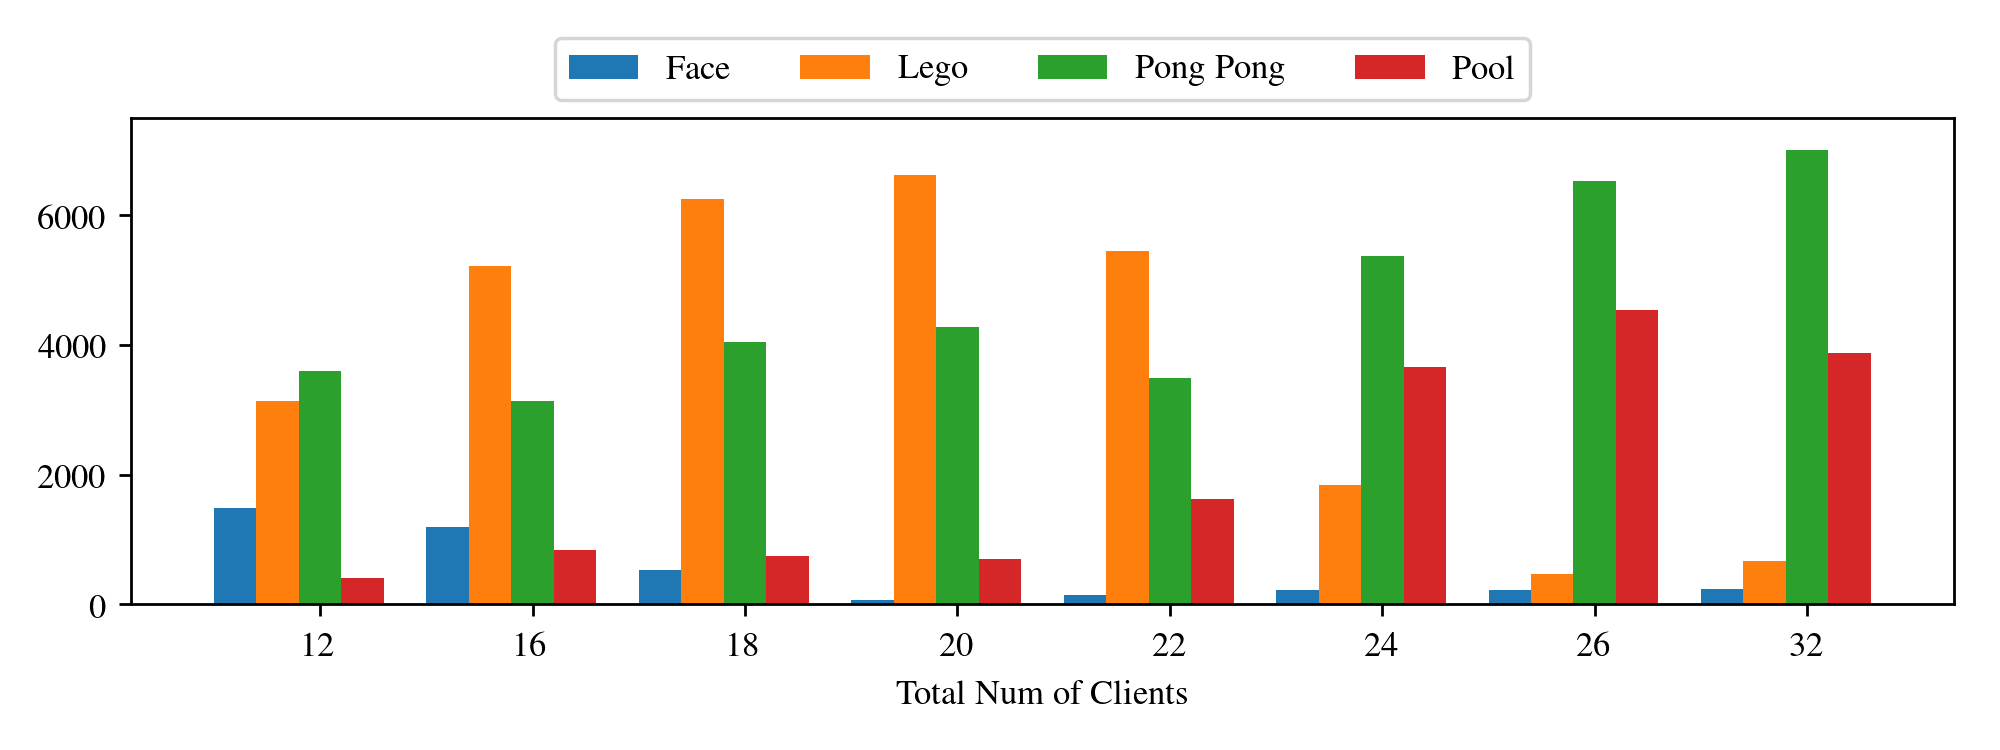

<IPython.core.display.Javascript object>


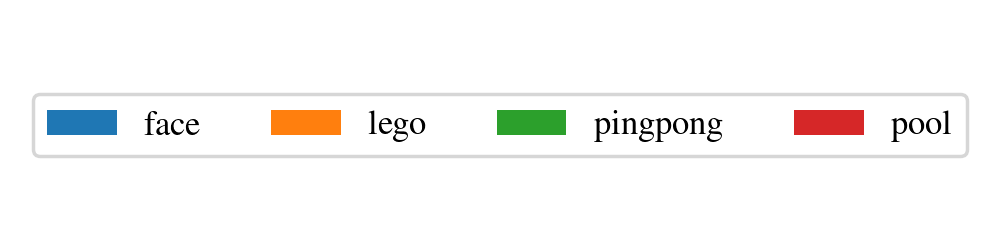

In [275]:
# plot breakdowns of individual apps
for scheme in schemes:
    app_utils = pd.DataFrame()
    
    for exp in exps:
        df = pd.read_sql(
            "select app, sum(utility) as utility from ExpLatency where name=%(name)s group by app",
            schema.engine,
            params={'name': exp+'-'+scheme}
        )
        df['exp'] = exp
        
        app_utils = app_utils.append(df, ignore_index=True)
        
    fig, ax = plt.subplots()
    ind = np.arange(len(exps))
    width = .2
    
    fig_legend = plt.figure(figsize=(4,1))
    
    lines=[]
    for i, app in enumerate(apps):
        ln = ax.bar(ind + width*i, app_utils[app_utils['app']==app]['utility'], width, label=pretty_app(app))
        lines.append(ln)
    fig_legend.legend(lines, apps, 'center', ncol=4)
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(exps_clients)
    ax.set_xlabel('Total Num of Clients')
    ax.set_ylim([0, 7500])
    fig.set_size_inches((8,3))
    ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)
    fig.tight_layout()
    fig.savefig('figs/fig-alloc-{}.pdf'.format(scheme), bbox_inches='tight')
            

fig_legend.show()

### Plot 90-th tile latency of each application

In [8]:
# plot 90%-tile/avg latencies of individual apps
def plot_latency(exps, schemes, apps, prefix):

    for scheme in schemes:
        app_latency = pd.DataFrame()
        for exp in exps:
            df = pd.read_sql(
                "select name, app, reply as latency from ExpLatency where name like %(name)s",
                schema.engine,
                params={'name': exp+'-'+scheme+'%',}
            )

            for app in apps:
                df_app = df[df['app']==app]
                latency = np.percentile(df_app['latency'].values, 90)  # 90%-tile
                count = df_app['latency'].count()

                app_latency = app_latency.append({
                    'exp': exp,
                    'app': app,
                    'latency': latency,
                    'count': count
                    }, ignore_index=True)

        fig, ax = plt.subplots()
        ind = np.arange(len(exps))
        
        legend_lns = []

        # per-app latency
        width = .18

        for i, app in enumerate(apps):
            x = ind + width*i
            y = app_latency[app_latency['app']==app]['latency'].values

            lb, ub = app_bounds[app]

            y1 = np.ones_like(y)
            y1[y < lb] = y[y < lb] / lb
            y1[np.logical_and(lb <= y, y <= ub)] = 1. + (y[np.logical_and(lb <= y, y <= ub)] - lb) / (ub - lb)
            y1[y > ub] = 1. + y[y > ub] / ub

            ln = ax.bar(x, y1, width, label=pretty_app(app), edgecolor='dimgrey', hatch=patterns[i])
#             ln = ax.bar(x, y1, width, label=pretty_app(app))
            legend_lns.append(ln)

        ax.hlines(1., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')
        ax.hlines(2., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')

        ax.set_yticks([1., 2.])
        ax.set_yticklabels(['Tight\n bound', 'Loose\n bound'])
        ax.set_xticks(ind + width * len(apps) / 2 )
        ax.set_xticklabels(exps_clients)
        ax.set_xlabel('Total Number of Clients')
        ax.set_ylabel('Normalized Latency')
        ax.set_ylim([0, 4.])

        fig.set_size_inches((4, 2))
        fig.tight_layout()
        fig.savefig('figs/fig-{}-latency-{}.pdf'.format(prefix, scheme), bbox_inches='tight')
        
        # save legend to separate figure
        fig_legend = plt.figure(figsize=(4, .25))
        fig_legend.legend(legend_lns, map(pretty_app, apps), 'center', ncol=5)
        fig_legend.savefig('figs/fig-{}-latency-legend.pdf'.format(prefix), bbox_inches='tight')

<IPython.core.display.Javascript object>


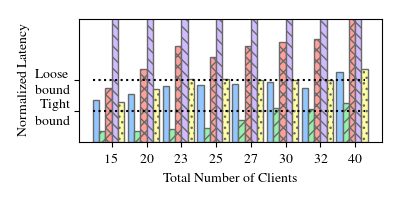

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


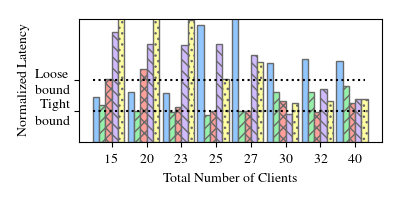

<IPython.core.display.Javascript object>

In [30]:
%matplotlib notebook
import matplotlib.style as style
style.use('seaborn-pastel')
matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.major.size'] = 3.5
matplotlib.rcParams['ytick.left'] = True
matplotlib.rcParams['ytick.major.size'] = 3.5

patterns = ('', '///', 'xxx', '\\\\\\', '...')
plot_latency(exps, schemes, apps, 'alloc')

### Plot FPS

<IPython.core.display.Javascript object>


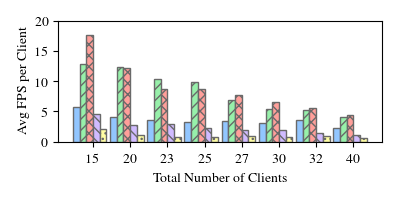

<IPython.core.display.Javascript object>


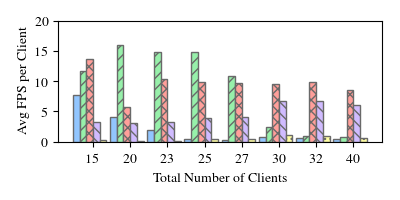

<IPython.core.display.Javascript object>


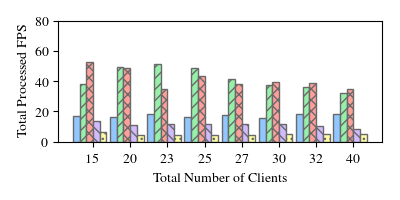

<IPython.core.display.Javascript object>


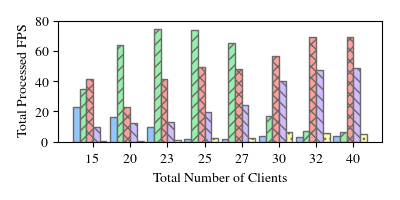

In [20]:
%matplotlib notebook

def exp_app_clients(name):
    r = re.findall('\d+', name.split('-')[-1])
    r = map(int, r)
    return dict(zip(['face', 'pool', 'pingpong', 'lego', 'ikea'], r))

# support both for average (per client) or total
def plot_fps(mode='average', save=True):
    if mode == 'average':
        ylabel = 'Avg FPS per Client'
        ylim = 20
    elif mode == 'total':
        ylabel = 'Total Processed FPS'
        ylim = 80
    else:
        raise ValueError('Unsupported mode ({})'.format(mode))
    
    for scheme in schemes:
        app_frames = pd.DataFrame()

        for exp in exps:
            df = pd.read_sql(
                "select app, count(*)/count(distinct name) as frames from ExpLatency where name like %(name)s group by app",
                schema.engine,
                params={'name': exp+'-'+scheme+'%',}
            )

            df['exp'] = exp

            app_frames = app_frames.append(df, ignore_index=True)

        fig, ax = plt.subplots()
        ind = np.arange(len(exps))
        width = .18

        for i, app in enumerate(apps):
            x = ind + width*i
            this_app = app_frames[app_frames['app']==app]
            this_app_clients = np.array([exp_app_clients(name)[app] for name in this_app['exp']])
            if mode == 'average':
                # y is average fps
                y = this_app['frames'].values / (this_app_clients * experiment_time)
            elif mode == 'total':
                y = this_app['frames'].values / (experiment_time)                

            ax.bar(x, y, width, label=pretty_app(app), edgecolor='dimgrey', hatch=patterns[i])

        ax.set_xticks(ind + width * len(apps) / 2 )
        ax.set_xticklabels(exps_clients)
        ax.set_xlabel('Total Number of Clients')
        ax.set_ylabel(ylabel)
        ax.set_ylim([0, ylim])

        fig.set_size_inches((4, 2.))
        fig.tight_layout()
        if save:
            fig.savefig('figs/fig-alloc-fps-{}.pdf'.format(scheme), bbox_inches='tight')

plot_fps('average')
plot_fps('total', save=False)

Reasons for pools average FPS to be increasing can be due to the inaccuracies of lego and pool's profile. 
The estimated pool's performance is lower than expected, while higer for lego. 

Lego is allowed to have more clients (6) > pool clients (2). Making it able to send more request maybe?

## Combined Evaluation: Workload Reduction + Resource Allocation (But still with frame-level evaluation)

#### Plot 90th Latency

<IPython.core.display.Javascript object>


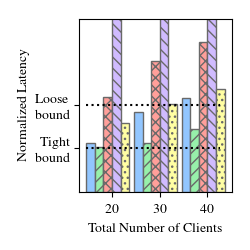

<IPython.core.display.Javascript object>


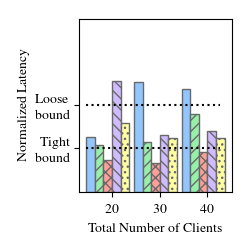

In [21]:
prefix = 'eval'
sec6_exps = [4, 6, 8]
for scheme in ['baseline', 'cpushares']:
    app_latency = pd.DataFrame()

    for exp in sec6_exps:
        df = pd.read_sql(
            "select name, app, reply as latency from ExpLatency where name=%(name)s",
            schema.engine,
            params={'name': 'sec6-fppli{1}-{0}'.format(scheme, exp)}            
        )

        for app in apps:
            df_app = df[df['app']==app]
            latency = np.percentile(df_app['latency'].values, 90)  # 90%-tile

            app_latency = app_latency.append({
                'exp': exp,
                'app': app,
                'latency': latency,
                }, ignore_index=True)

    fig, ax = plt.subplots()
    ind = np.arange(len(sec6_exps))

    # per-app latency
    width = .18

    for i, app in enumerate(apps):
        x = ind + width*i
        y = app_latency[app_latency['app']==app]['latency'].values

        lb, ub = app_bounds[app]

        y1 = np.ones_like(y)
        y1[y < lb] = y[y < lb] / lb
        y1[np.logical_and(lb <= y, y <= ub)] = 1. + (y[np.logical_and(lb <= y, y <= ub)] - lb) / (ub - lb)
        y1[y > ub] = 1. + y[y > ub] / ub

        ax.bar(x, y1, width, label=pretty_app(app), edgecolor='dimgrey', hatch=patterns[i])

    ax.hlines(1., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')
    ax.hlines(2., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')

    ax.set_yticks([1., 2.])
    ax.set_yticklabels(['Tight\n bound', 'Loose\n bound'])
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(np.array(sec6_exps)*len(apps))
    ax.set_xlabel('Total Number of Clients')
    ax.set_ylabel('Normalized Latency')
    ax.set_ylim([0, 4.])

    fig.set_size_inches((2.5, 2.5))
    fig.tight_layout()
    fig.savefig('figs/fig-{}-latency-{}.pdf'.format(prefix, scheme), bbox_inches='tight')

### Plot Average FPS

<IPython.core.display.Javascript object>


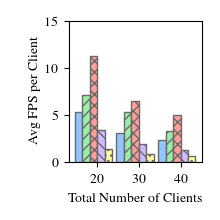

<IPython.core.display.Javascript object>


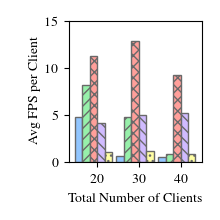

In [22]:
%matplotlib notebook
# Plot processed fps
for scheme in ['baseline', 'cpushares']:
    app_frames = pd.DataFrame()
    
    for exp in sec6_exps:
        df = pd.read_sql(
            "select app, count(*) as frames from ExpLatency where name like %(name)s group by app",
            schema.engine,
        params={'name': 'sec6-fppli{1}-{0}'.format(scheme, exp)}            

        )
        df['exp'] = exp
        app_frames = app_frames.append(df, ignore_index=True)
        
    
    fig, ax = plt.subplots()
    ind = np.arange(len(sec6_exps))
    width = .18
    
    for i, app in enumerate(apps):
        x = ind + width*i
        this_app = app_frames[app_frames['app']==app]
        y = np.divide(this_app['frames'].values, np.array(map(float, sec6_exps))) / 90 # experiment        
        ax.bar(x, y, width, label=pretty_app(app), edgecolor='dimgrey', hatch=patterns[i])
    
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(np.array(sec6_exps) * len(apps))  # hard code
    ax.set_xlabel('Total Number of Clients')
    ax.set_ylabel('Avg FPS per Client')
    ax.set_ylim([0, 15])
    fig.set_size_inches((2.2, 2.2))
    fig.tight_layout()
    fig.savefig('figs/fig-{}-fps-{}.pdf'.format(prefix, scheme), bbox_inches='tight')

Questions:
1. why does pool's average FPS per client increase? It seems that at maximum it should remain the same instead of increasing.
2. why does the pool's estimated performance a lot higher than actual performance?

## Plot: Resource Allocated For Each App on Cloudlet

Below code should be run without running the previous block to use matplotlib default colormap instead of seaborn package's default.

       FACE      LEGO  PING PONG      POOL      IKEA
0  0.123820  0.247640   0.247640  0.371823  0.009078
1  0.013376  0.060460   0.364901  0.547887  0.013376
2  0.014594  0.014594   0.358435  0.597782  0.014594


<IPython.core.display.Javascript object>


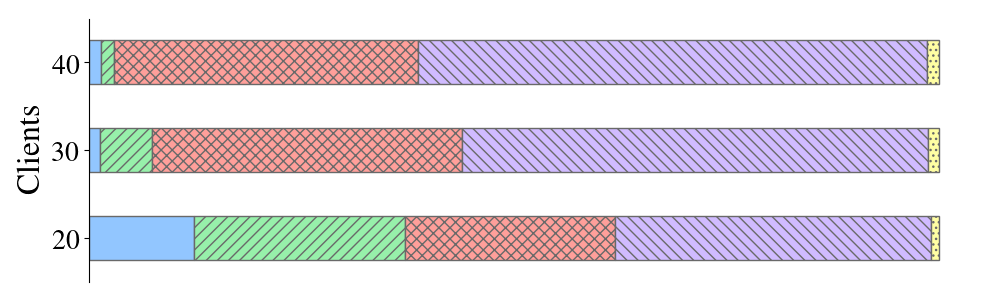

('', '///', 'xxx', '\\\\\\', '...')
15


In [40]:
labels = ['FACE', 'LEGO', 'PING PONG', 'POOL', 'IKEA']
res_allocation = [
    [341, 682, 682, 1024, 25],
    [25, 113, 682, 1024, 25],
    [25, 25, 614, 1024, 25]
]


df = pd.DataFrame(res_allocation, columns=labels)
#df = df.cumsum(axis=1)
df = df.divide(df.sum(axis=1), axis="index")
#df['clients'] = [16, 24, 32]
print(df)

import matplotlib.font_manager as font_manager
fig, ax = plt.subplots()
df.plot(kind='barh', stacked=True, ax=ax, sort_columns=True,  figsize=(10, 3), edgecolor='dimgrey')

bars = ax.patches
print(patterns)
print(len(bars))

flatten = []
for pat in patterns:
    flatten.extend([pat]*3)

import itertools
for bar, pattern in zip(bars, flatten):
    bar.set_hatch(pattern)

# ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.45, 1.3), prop={'weight':1000, 'size': 21})
ax.get_xaxis().set_visible(False)
ax.set_yticklabels(['20', '30', '40'])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('Clients', fontsize=23)
ax.tick_params(axis='y', labelsize=20)
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('figs/fig-sec6-latency-allocation.pdf', bbox_inches=0)